# Enfoque alternativo de modelación.
A continuación, se presenta un enfoque alternativo para enfrentar la modelación del problema. Este se basa en generar segmentos dentro del set de datos y para cada uno entrenar un modelo diferente.

In [1]:
from pathlib import Path

# Manipulando datos
import pandas as pd
import numpy as np
import csv
from yaml.loader import SafeLoader
import json
import yaml
import statistics
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import tree
 

from sklearn import tree
# Librerías para preprocesamiento
from sklearn.preprocessing import MinMaxScaler 

# librería que muestra los warning 
import warnings   
warnings.filterwarnings("ignore", category=DeprecationWarning) 

plt.style.use("seaborn")
import glob   # trae las rutas de archivo de una ruta especifica
import os # trae las rutas de los archivos


from skimpy import clean_columns
import missingno as msno
import pickle

# Import psycopg2
from psycopg2 import connect, extensions, sql
from sqlalchemy import create_engine

# Librerías para reporte de métricas
from sklearn.metrics import mean_squared_error, median_absolute_error, r2_score

# Funciones custom
from lib.functDescriptiveAnalysis import inspectDataFrameDA, countNaNDA
from lib.functCleanData import convert_float, whitespaceRemover
from lib.functReportGraficas import plot_importance, resultados_modelo
from lib.functModels import get_scaled_matrix, fit_or_load_model, calcular_error_modelo, segmentation_model

from sklearn.linear_model import LinearRegression



# Módulos de modelos
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import ElasticNetCV          # Modelo 1 
from sklearn.linear_model import SGDRegressor          # Modelo 2 
from sklearn.ensemble import GradientBoostingRegressor # Modelo 3
from sklearn.tree import DecisionTreeRegressor         # Modelo 4
from sklearn.ensemble import RandomForestRegressor     # Modelo 5


from sklearn.pipeline import make_pipeline

In [2]:
df = pickle.load(open('data/output/dataset_pre_modelacion.plk', 'rb'))
with pd.option_context("display.max_columns", None):
    display(df.head(n = 5))

,order_id,lat_order,lng_order,dow,promised_time,actual_time,on_demand,picker_id,driver_id,store_branch_id,total_minutes,actual_reception_time,promised_delivery_time,total_minutes_td,order_time,model_1_dt_time,model_1_time,store,lat_store,lng_store,shopper_id_picker,seniority_picker,found_rate_picker,picking_speed_picker,accepted_rate_picker,rating_picker,shopper_id_driver,seniority_driver,found_rate_driver,picking_speed_driver,accepted_rate_driver,rating_driver,total_product,real_total_unit,real_total_kg,real_without_product,total_unit,total_kg,distancia,hora_de_pedido_aprox,horario
0,6abd5e28d01b7c733fe37485294235dc,18.22114,-10.03139,2,13:00:00,12:00:15,False,09bb5bfe76adbb474dddbdd111a51623,09bb5bfe76adbb474dddbdd111a51623,0dc6fb5924a8b917bc641666ed02663c,91.800861,1900-01-01 12:00:15,1900-01-01 13:00:00,0 days 01:31:48.051660,1900-01-01 10:28:26.948340000,0 days 02:31:33.051660,151.550861,60e4c4e1c1a8bc79123738227b9d0b08,18.23190,-10.03035,09bb5bfe76adbb474dddbdd111a51623,ADVANCED,0.86,1.56,1.00,4.68,09bb5bfe76adbb474dddbdd111a51623,ADVANCED,0.86,1.56,1.00,4.68,27.0,18.0,6.245,1.0,19.0,5.722,1.201490,10,HorarioPunta
1,0d37a1eea001f01b40232ffd496ff663,18.17771,-10.03570,2,13:00:00,10:28:10,False,c4c722114a82fa21654e57e9636d68b0,c4c722114a82fa21654e57e9636d68b0,2bbf833e689d24b697f1f3529c3f3c4b,206.599732,1900-01-01 10:28:10,1900-01-01 13:00:00,0 days 03:26:35.983919999,1900-01-01 07:01:34.016080001,0 days 05:58:25.983919999,358.433065,387d4a5b65cf4bf00ad805c4b00eed01,18.16396,-10.03289,c4c722114a82fa21654e57e9636d68b0,ADVANCED,0.85,1.14,1.00,4.76,c4c722114a82fa21654e57e9636d68b0,ADVANCED,0.85,1.14,1.00,4.76,103.0,114.0,40.614,20.0,150.0,39.562,1.557488,7,HorarioValle
2,528428e9b9eb5d3bd0dbdd8da692b087,18.26683,-10.03175,2,11:00:00,10:40:50,False,e15c7a67d0ea9a54dffb410bc1d8528b,e15c7a67d0ea9a54dffb410bc1d8528b,8d891dfc0e29d744c15c18adced74a68,93.458001,1900-01-01 10:40:50,1900-01-01 11:00:00,0 days 01:33:27.480060,1900-01-01 09:07:22.519940000,0 days 01:52:37.480060,112.624668,0fae7b61265bc7ca4ce4d81440b62501,18.24565,-10.03324,e15c7a67d0ea9a54dffb410bc1d8528b,INTERMEDIATE,0.83,2.03,1.00,4.96,e15c7a67d0ea9a54dffb410bc1d8528b,INTERMEDIATE,0.83,2.03,1.00,4.96,6.0,6.0,0.000,0.0,6.0,0.000,2.360362,9,HorarioPunta
3,d3f7be6d64eae7405b7bf024e04807a2,18.24888,-10.03226,2,10:00:00,9:41:47,False,d1f0bd4b237c1358f09db22076b940e7,d1f0bd4b237c1358f09db22076b940e7,0dc6fb5924a8b917bc641666ed02663c,124.778761,1900-01-01 09:41:47,1900-01-01 10:00:00,0 days 02:04:46.725660,1900-01-01 07:37:00.274340000,0 days 02:22:59.725660,142.995428,60e4c4e1c1a8bc79123738227b9d0b08,18.23190,-10.03035,d1f0bd4b237c1358f09db22076b940e7,INTERMEDIATE,0.86,2.06,0.92,4.92,d1f0bd4b237c1358f09db22076b940e7,INTERMEDIATE,0.86,2.06,0.92,4.92,17.0,18.0,19.805,1.0,20.0,18.300,1.898837,7,HorarioValle
4,e0ad6533b6cd9a382ec6c1d473c5036c,18.22911,-10.03226,2,11:00:00,10:07:53,False,06a71e8ab0c6db5ce22a4689fd76a3f4,06a71e8ab0c6db5ce22a4689fd76a3f4,afd0a7b8d546fcc697bb93a5934b65c3,130.321208,1900-01-01 10:07:53,1900-01-01 11:00:00,0 days 02:10:19.272480,1900-01-01 07:57:33.727520000,0 days 03:02:26.272480,182.437875,452ae015bf846e1d2932b7ea15720d64,18.23159,-10.03145,06a71e8ab0c6db5ce22a4689fd76a3f4,ADVANCED,0.86,1.89,1.00,4.92,06a71e8ab0c6db5ce22a4689fd76a3f4,ADVANCED,0.86,1.89,1.00,4.92,44.0,28.0,11.575,3.0,31.0,7.721,0.288728,7,HorarioValle


Primero, dados distintos análisis, se realiza una categorización binaria por cantidad total de producto de cada pediudo. Para los casos en que es mayor o igual a 19, se marca como 1, en otro caso es 0. Esto busca diferenciar aquellos pedidos grandes de pedidos pequeños. Este límite se ha escogido por medio de ensayo y error. Además, genera dos grupos con una buena cantidad de datos, poca varianza dentro del grupo y alta varianza entre grupos.

In [3]:
df['total_product_cat'] = (
    np.where(df['total_product'] >= 19, 1, 0))
            #np.where(df['total_product'] >= 8, 1,
             #       0)))

Hecho lo anterior, se continúa con el proceso normalmente.

In [4]:
df_modelo = df.copy()
df_modelo = df_modelo.drop(columns = ['lat_order', 'lng_order', 'promised_time',
       'actual_time', 'picker_id', 'driver_id',
       'actual_reception_time', 'promised_delivery_time', 'shopper_id_driver',
       'total_minutes_td', 'order_time', 'model_1_dt_time', 'model_1_time',
       'store', 'lat_store', 'lng_store', 'shopper_id_picker',
        'real_without_product', 'real_total_kg', 'real_total_unit'])


In [5]:
df_modelo.groupby(['horario'], as_index = False)['total_minutes'].agg([np.mean, np.std, np.ma.count])

,mean,std,count
horario,,,
HorarioNocturno,561.511852,289.954648,25
HorarioPunta,80.701262,45.661128,2724
HorarioValle,82.913140,56.997284,3739


**Comentarios**  
Como primer enfoque de segmentación se pensó en el horario. El problema que tiene este enfoque es que los dos segmentos con más observaciones no tienen gran diferencia en su promedio de total_minutes. En cambio, el segmento que sí se diferencia (nocturno) solo queda con 25 observaciones.

In [6]:
df_modelo.groupby(['seniority_picker'], as_index = False)['total_minutes'].agg([np.mean, np.std, np.ma.count])

,mean,std,count
seniority_picker,,,
ADVANCED,87.120339,66.008592,3493
BEGINNER,81.754461,41.446622,70
INTERMEDIATE,79.778340,58.287545,2041
REVIEW,80.337687,60.445196,884


**Comentarios**  
Otro enfoque potencial fue el del seniority picker, sin embargo, se descartó dado que no hay diferencias significativas en total_minutes entre segmentos.

In [7]:
df_modelo.groupby(['total_product_cat'], as_index = False)['total_minutes'].agg([np.mean, np.std, np.ma.count])

,mean,std,count
total_product_cat,,,
0,72.436183,59.724180,4212
1,104.911714,62.876417,2276


**Comentarios**  
Por último, el enfoque de total_product_cat, que diferencia pedidos de muchos productos vs los de poco sí tiene más sentido. Vemos que ambas categorías tienen una cantidad considerable de observaciones. Además, se observa que aquellos pedidos que tienen total_product_cat = 1 tienen un tiempo promedio considerablemente mayor. Lo anterior nos sirve para que sean clases que se diferencien claramente.

## Preparación modelos
A continuación, se realizan los pasos necesarios para entrenar los distintos modelos.

In [8]:
# Las variables dow y hora pedido son transformadas o object para que get_dummies funcione correctamente
variables_numericas_recodificar = ["dow", "hora_de_pedido_aprox"]
for col in variables_numericas_recodificar:
    df_modelo[col] = 'c' + df_modelo[col].astype(str) 
df_modelo.head()

,order_id,dow,on_demand,store_branch_id,total_minutes,seniority_picker,found_rate_picker,picking_speed_picker,accepted_rate_picker,rating_picker,...,picking_speed_driver,accepted_rate_driver,rating_driver,total_product,total_unit,total_kg,distancia,hora_de_pedido_aprox,horario,total_product_cat
0,6abd5e28d01b7c733fe37485294235dc,c2,False,0dc6fb5924a8b917bc641666ed02663c,91.800861,ADVANCED,0.86,1.56,1.00,4.68,...,1.56,1.00,4.68,27.0,19.0,5.722,1.201490,c10,HorarioPunta,1
1,0d37a1eea001f01b40232ffd496ff663,c2,False,2bbf833e689d24b697f1f3529c3f3c4b,206.599732,ADVANCED,0.85,1.14,1.00,4.76,...,1.14,1.00,4.76,103.0,150.0,39.562,1.557488,c7,HorarioValle,1
2,528428e9b9eb5d3bd0dbdd8da692b087,c2,False,8d891dfc0e29d744c15c18adced74a68,93.458001,INTERMEDIATE,0.83,2.03,1.00,4.96,...,2.03,1.00,4.96,6.0,6.0,0.000,2.360362,c9,HorarioPunta,0
3,d3f7be6d64eae7405b7bf024e04807a2,c2,False,0dc6fb5924a8b917bc641666ed02663c,124.778761,INTERMEDIATE,0.86,2.06,0.92,4.92,...,2.06,0.92,4.92,17.0,20.0,18.300,1.898837,c7,HorarioValle,0
4,e0ad6533b6cd9a382ec6c1d473c5036c,c2,False,afd0a7b8d546fcc697bb93a5934b65c3,130.321208,ADVANCED,0.86,1.89,1.00,4.92,...,1.89,1.00,4.92,44.0,31.0,7.721,0.288728,c7,HorarioValle,1


In [9]:
# Senoritypicker y senioritydriver son transformadas en niveles
df_modelo['seniority_picker'] = df_modelo['seniority_picker'].replace(
    ['ADVANCED', 'INTERMEDIATE', 'REVIEW', 'BEGINNER'],
    [3, 2, 1, 0]
)

df_modelo['seniority_driver'] = df_modelo['seniority_driver'].replace(
    ['ADVANCED', 'INTERMEDIATE', 'REVIEW', 'BEGINNER'],
    [3, 2, 1, 0]
)

In [10]:
for col, dtype in df_modelo.dtypes.iteritems():
    if dtype == 'O' and col != 'order_id':
        dummies = pd.get_dummies(df_modelo[col], prefix=col, drop_first=True)
        df_modelo = pd.concat([df_modelo, dummies], axis=1).drop(columns=[col])

In [11]:
with pd.option_context("display.max_columns", None):
    display(df_modelo.head(n = 5))

,order_id,on_demand,total_minutes,seniority_picker,found_rate_picker,picking_speed_picker,accepted_rate_picker,rating_picker,seniority_driver,found_rate_driver,picking_speed_driver,accepted_rate_driver,rating_driver,total_product,total_unit,total_kg,distancia,total_product_cat,dow_c1,dow_c2,dow_c3,dow_c4,dow_c5,dow_c6,store_branch_id_02020427c72aa211602ead141160a9eb,store_branch_id_0302e4778cdaf296d9b69564e6296b6b,store_branch_id_0309659a74b54b7933aa6c0571497d9b,store_branch_id_0a5262149db2b5b849da2128cee09358,store_branch_id_0cdeb3c8700028cdf750409d66e354da,store_branch_id_0dc6fb5924a8b917bc641666ed02663c,store_branch_id_144aa59c494a4450656ced49ea400d1b,store_branch_id_15bf16e04b6f5e730f38a7c6a4b47f21,store_branch_id_1679232b44bbe5c756a345fff42acd36,store_branch_id_16e537c9d1bf9a530aea9af2c8020f52,store_branch_id_175d039c07ea5128fa4e5ec01902a710,store_branch_id_1ab8f7f99a1730f85df0b9e503c1a319,store_branch_id_1f660027cb64313d072c844d9fdc31e4,store_branch_id_1fab95c4c6d7555f391a045b4881b423,store_branch_id_1fc727dd540d924d2370b4d6ec0149fd,store_branch_id_215f4c85edb5fd23b7b095104bc34cb2,store_branch_id_21a6aed891ee4844c56a063a79a50208,store_branch_id_22dcadd55bcd012e63ececc69c55bb74,store_branch_id_258f4c26a82a5239920a082ffe23cfc4,store_branch_id_25b1e6be606fe62b5770a5bfaf25bfec,store_branch_id_2771c8bdd43c6357cce12f9d946dcf75,store_branch_id_2aa560c85aeb4213b9af8bdd05805b91,store_branch_id_2bbf833e689d24b697f1f3529c3f3c4b,store_branch_id_2d69acabaafd2516eeffd3c69b3c1328,store_branch_id_37d89853e51879008c528640f48cf420,store_branch_id_383930af40caaa13760a10a9d6f418ab,store_branch_id_3ad5bfb1ba9eb8e0b76bdbaf0d8e6a3a,store_branch_id_3d8ac35d74ad2f875847247ebfd716ca,store_branch_id_3dd9ae393aa5327edfb27388758436bd,store_branch_id_3ddd4c29cab4178d89d549c6ba65c236,store_branch_id_3ecb75411e187833a1b822a0eaa255fa,store_branch_id_41ca3a65599fb02ab0d0cdd23da1e922,store_branch_id_41d9a054007bfce5cd838d2f9b2d7db3,store_branch_id_49b7d60d6095a9f1129ce798102b62f4,store_branch_id_4a07fa0a140101e2270d5b95e7583401,store_branch_id_4a07fce9f9c16c911b8821717905a0d3,store_branch_id_4d4f7045619dd94fd41ddb64fbccf9f5,store_branch_id_4e1e1ec3892a5523e0d139f9aff41301,store_branch_id_4f01884af565f4d2df35419e09cf58d0,store_branch_id_539fefbf8bd77f800d05b04cce7b0f07,store_branch_id_57eb965a3305343348a2c179a610dce1,store_branch_id_585d8f4f36bc74acf0fc1fae7913b404,store_branch_id_58dc6da0edd08253743c7ed41280bcfc,store_branch_id_5a6dd51ef5ed276079b6a102d4ceb8f6,store_branch_id_6045691f87544c937a09d350d42eb3ba,store_branch_id_61c357d4bbf6b7421032a467b616f879,store_branch_id_6447951cd071f6f045fd4e6194920926,store_branch_id_64a244c174e03776c96385894252f149,store_branch_id_64f6f160b2937501d7627285c5994b38,store_branch_id_69803373c7d9ae282a73c00e69f119b4,store_branch_id_6cd78596c7bf5ef34f3d5c197ef2ee8e,store_branch_id_6ff95b527827f48461836b1c64f48771,store_branch_id_70d57522d7e36733fe5015e687bea6f3,store_branch_id_72238a1ce4cf02d9744926a5c8ac4368,store_branch_id_75d034354b7c54e65b50193f8f987386,store_branch_id_762276b0a3d020a8393c26579a6e5e7f,store_branch_id_7a44728dc60bafc53140a9f5ef7e4e75,store_branch_id_7b571744f2c64bcff08d971a64584874,store_branch_id_7c5c15309c5aecf4009261f4de305f6b,store_branch_id_821dc9d74061fe7654b9ec20e574022d,store_branch_id_82862bb4ff9734b6f8fee2dcde6be96f,store_branch_id_83c1570496a3ead7f4202afb827d59bb,store_branch_id_850fc42b029db68d97f0aea6a8babe36,store_branch_id_86e6e48d0cb57f794b0c48162409fa74,store_branch_id_88c1e4665f49718496981b3228416f35,store_branch_id_8a0d17a3597b726e5ea4962c78f5715a,store_branch_id_8ade020f4c949f4e00ca91082d63a17e,store_branch_id_8d891dfc0e29d744c15c18adced74a68,store_branch_id_8f21cfda17b340aeee062220d0bee8e5,store_branch_id_90d3e898952320088d3de585f75a4873,store_branch_id_938420c4980439b9655c61c85b81333e,store_branch_id_95f4e98f4cc7d7902f1d1a8ab7f91ed5,store_branch_id_98f1ed7ef085ea37c8c55c5c2fa71593,store_branch_id_9a5936caaadf0204c75858717f7599dc,store_branch_id_9bbed42bb27f81a5bfd0d20362f166d9,store

## Modelación
A continuación, se modelan las distintas partes que conllevarán a los modelos combinados. Luego, se presentan los distintos modelos. Los comentarios sobre los errores y desempeños de los modelos se realiza al final.

### Generación de grillas y modelos 

In [12]:
# ElasticNet
grid_en = {
    'l1_ratio':[.1, .25, .5, 1],
    'n_alphas': [1, 5, 10, 20]
    }

model_en = ElasticNetCV(max_iter = 20000, random_state = 42)

# Gradient boost
grid_gbr = {
    'learning_rate': [0.01, 0.1, 0.5],
    'n_estimators': [100, 500, 1000, 2000],
    'subsample': [0.1,0.5, 1]
}

model_gbr = GradientBoostingRegressor(random_state = 42)

grid_rf = {"n_estimators": [10, 50, 100],
           "criterion": ['squared_error'],
           "max_depth":  np.linspace(2,32, dtype=int, num=4) , # genero el maximo de profundidad entre 1 y 32
           "max_features": list(range(7, int(np.sqrt(df_modelo.shape[1])))) #genero maximo atributos, genero un rango pero lo envuelvo en una lista desde 1 a la cantidad de columnas
           }
model_rf = RandomForestRegressor(random_state = 42)


### 1. ElasticNet puro
Modelo base que no segmenta. Solo aplica Elastic Net con gridsearch sobre el total de datos. En los casos de modelos "puros" se trata de modelos que no segmentan. Para no generar otra función, lo que se hace es generar una columna auxiliar llamada 'CantidadDatos' que siempre es igual a 1. Luego, se segmenta por esa columna, lo que es equivalente a no segmentar.

Fitting 5 folds for each of 16 candidates, totalling 80 fits
Los resultados para la variable CantidadDatos = 1 son:
El error cuadrático medio es 2005.00, mientras que su raiz es 44.78
El error absoluto mediano es 15.21
Comienza identificación de top n variables relevantes...


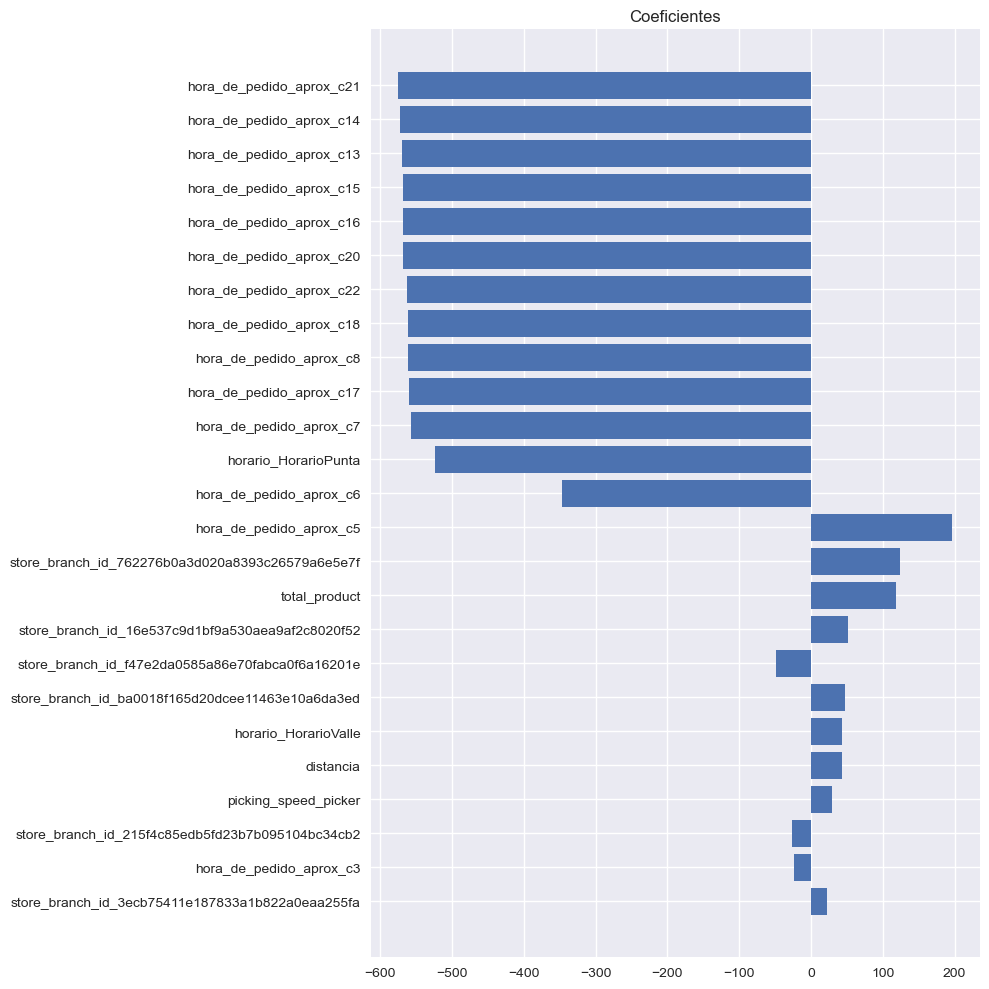

In [13]:
df_modelo_temp = df_modelo.copy()
df_modelo_temp['CantidadDatos'] = 1

models_list = [model_en]
grid_list = [grid_en]
var_group = 'CantidadDatos'

df_pred = segmentation_model(df_modelo_temp, models_list, var_group, grid_list, 'Elastic_Net_puro')


In [14]:
orders_test = df_pred 
orders_test.head()

,order_id,Elastic_Net_puro
0,c5fe2b7c2f032b84786701bfcc8e4fb4,106.219657
1,d455762a86db4f47f649f5235589ca8d,79.630490
2,d1b3af61078d65209e6d55aea6482856,74.203378
3,170136b204ce794ef73a3b8027725b68,108.926618
4,1cdd5e0e7f17a4fdb43d33ba8ec916d6,56.539377


### 2. GB puro
Mismo enfoqueque el primer modelo. Es un modelo puro.

Fitting 5 folds for each of 36 candidates, totalling 180 fits
Los resultados para la variable CantidadDatos = 1 son:
El error cuadrático medio es 3606.91, mientras que su raiz es 60.06
El error absoluto mediano es 15.89
Comienza identificación de top n variables relevantes...


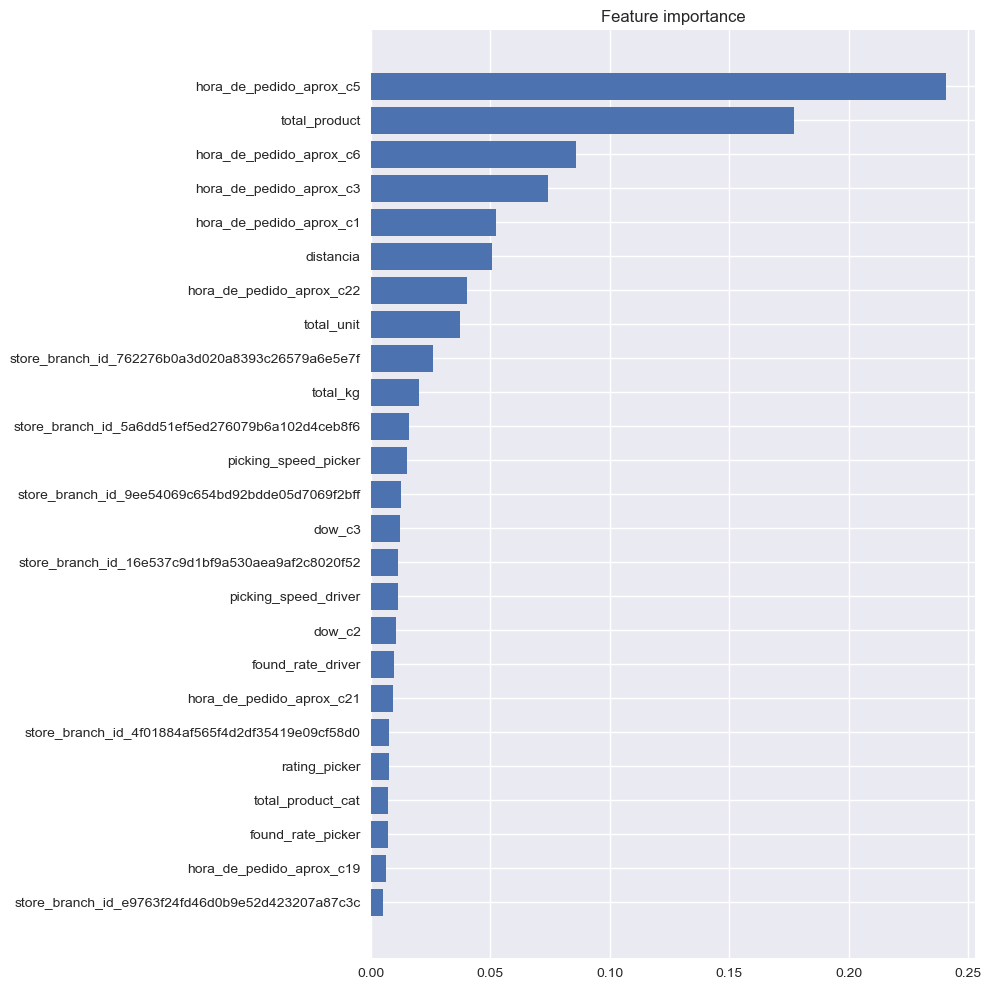

In [15]:
models_list = [model_gbr]
grid_list = [grid_gbr]
var_group = 'CantidadDatos'

df_pred = segmentation_model(df_modelo_temp, models_list, var_group, grid_list, 'Gradient_puro')


In [16]:
orders_test = pd.merge(orders_test, df_pred, how='inner', left_on = 'order_id', right_on = 'order_id')
orders_test.head()

,order_id,Elastic_Net_puro,Gradient_puro
0,c5fe2b7c2f032b84786701bfcc8e4fb4,106.219657,106.852542
1,d455762a86db4f47f649f5235589ca8d,79.630490,79.219511
2,d1b3af61078d65209e6d55aea6482856,74.203378,92.432045
3,170136b204ce794ef73a3b8027725b68,108.926618,96.395305
4,1cdd5e0e7f17a4fdb43d33ba8ec916d6,56.539377,64.589044


### 3. Random Forest puro

Fitting 5 folds for each of 60 candidates, totalling 300 fits
Los resultados para la variable CantidadDatos = 1 son:
El error cuadrático medio es 4038.67, mientras que su raiz es 63.55
El error absoluto mediano es 15.42
Comienza identificación de top n variables relevantes...


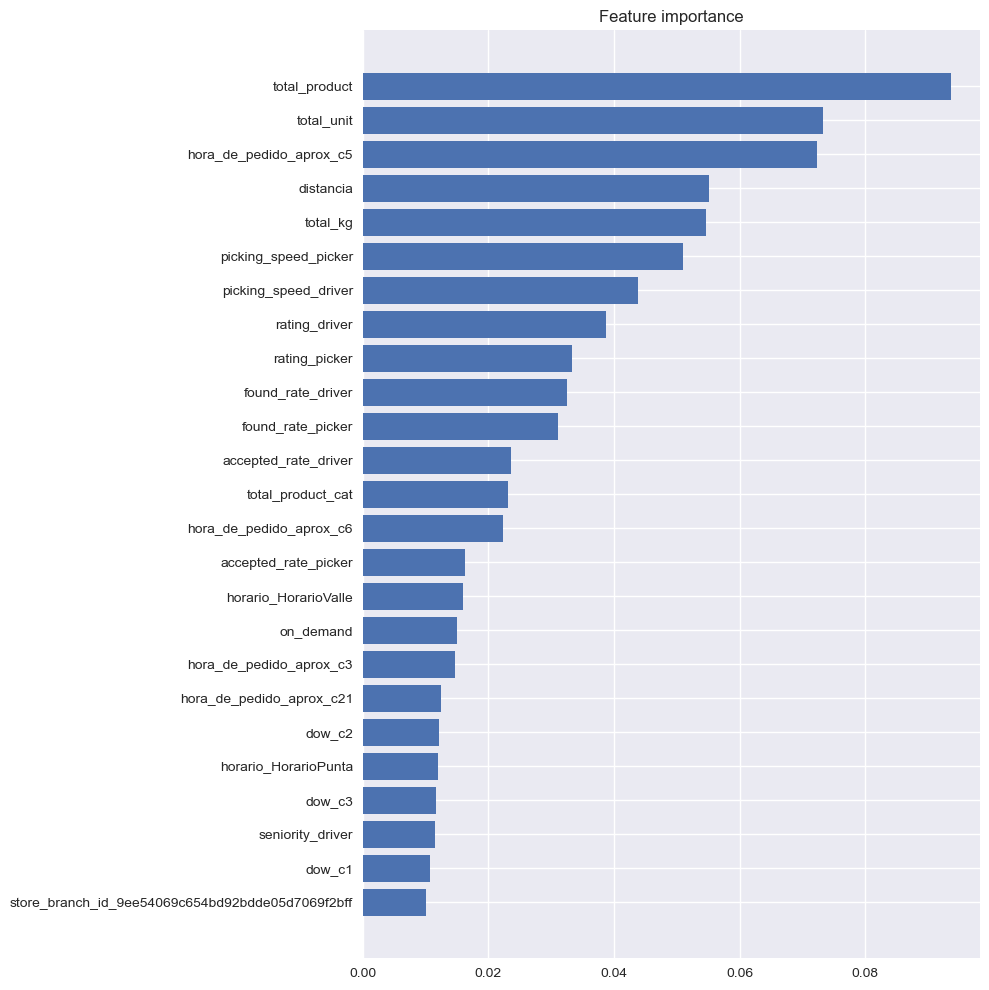

In [17]:
models_list = [model_rf]
grid_list = [grid_rf]
var_group = 'CantidadDatos'

df_pred = segmentation_model(df_modelo_temp, models_list, var_group, grid_list, 'rf_puro')


In [18]:
orders_test = pd.merge(orders_test, df_pred, how='inner', left_on = 'order_id', right_on = 'order_id')
orders_test.head()

,order_id,Elastic_Net_puro,Gradient_puro,rf_puro
0,c5fe2b7c2f032b84786701bfcc8e4fb4,106.219657,106.852542,96.294018
1,d455762a86db4f47f649f5235589ca8d,79.630490,79.219511,86.323151
2,d1b3af61078d65209e6d55aea6482856,74.203378,92.432045,78.895219
3,170136b204ce794ef73a3b8027725b68,108.926618,96.395305,104.622655
4,1cdd5e0e7f17a4fdb43d33ba8ec916d6,56.539377,64.589044,59.750017


## Modelos híbridos
A continuación, se presentan combinaciones construidas de modelos. Esto es, aplicar un tipo de modelo para un subconjunto de los datos y otro para el resto. No se presentan todas las combinaciones posibles por temas lógicos.

### 1. Elastic net según categoría de total product
Modelo que utiliza Elastic Net en ambos segmentos. En la práctica solo usa EN, sin embargo, son dos modelos EN combinados.

Fitting 5 folds for each of 16 candidates, totalling 80 fits
Los resultados para la variable total_product_cat = 0 son:
El error cuadrático medio es 1363.61, mientras que su raiz es 36.93
El error absoluto mediano es 14.53
Comienza identificación de top n variables relevantes...


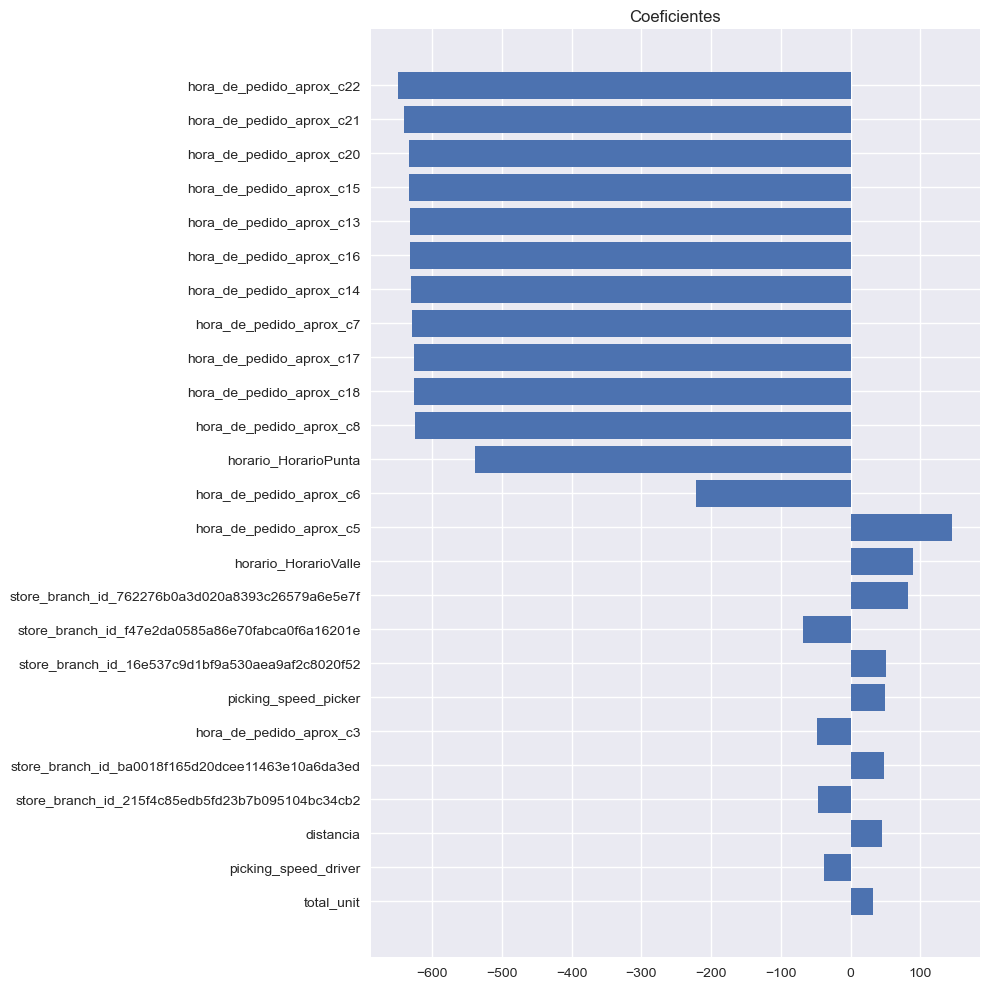


Fitting 5 folds for each of 16 candidates, totalling 80 fits
Los resultados para la variable total_product_cat = 1 son:
El error cuadrático medio es 4735.78, mientras que su raiz es 68.82
El error absoluto mediano es 16.57
Comienza identificación de top n variables relevantes...


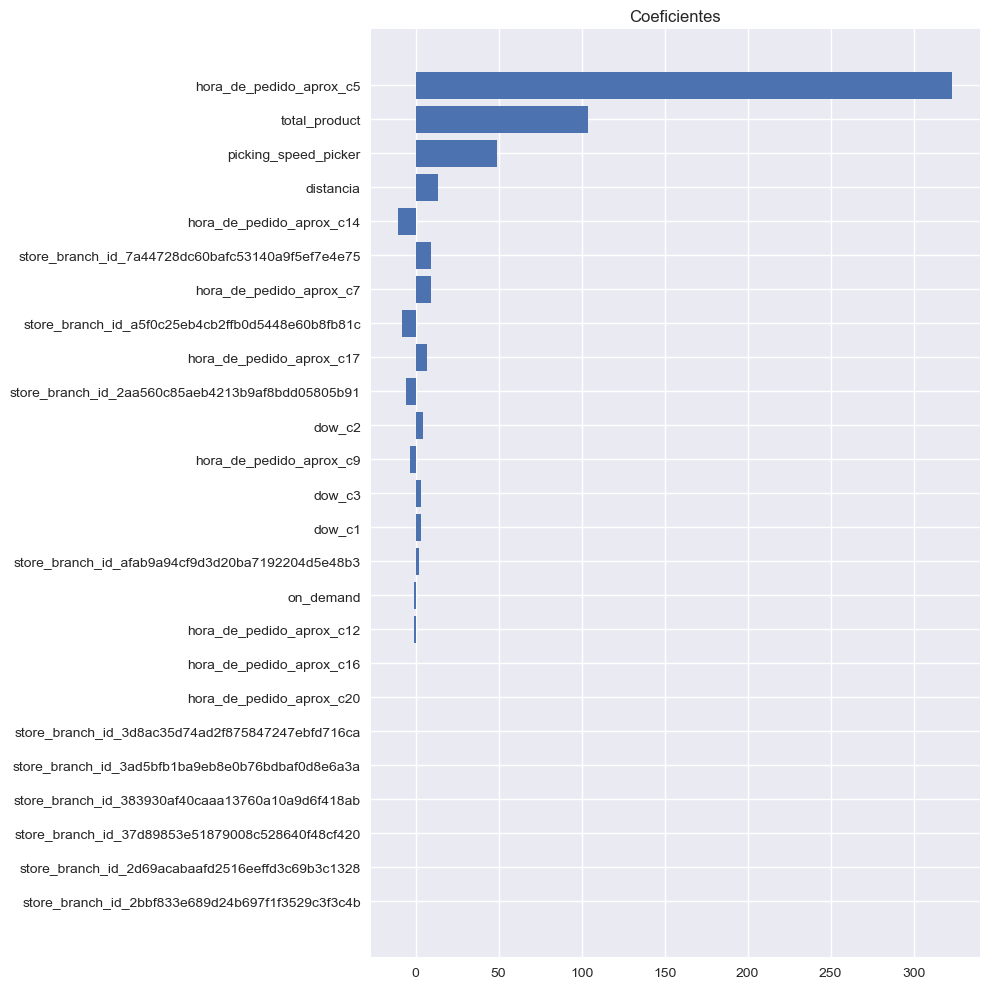

In [19]:
df_aux = df_modelo.copy()
models_list = [model_en, model_en]
grid_list = [grid_en, grid_en]
var_group = 'total_product_cat'

df_pred = segmentation_model(df_aux, models_list, var_group, grid_list, 'Elastic_Net_Cat')

In [20]:
orders_test = pd.merge(orders_test, df_pred, how='inner', left_on = 'order_id', right_on = 'order_id')
orders_test.head()

,order_id,Elastic_Net_puro,Gradient_puro,rf_puro,Elastic_Net_Cat
0,c5fe2b7c2f032b84786701bfcc8e4fb4,106.219657,106.852542,96.294018,106.771873
1,d455762a86db4f47f649f5235589ca8d,79.630490,79.219511,86.323151,75.229438
2,d1b3af61078d65209e6d55aea6482856,74.203378,92.432045,78.895219,82.564872
3,170136b204ce794ef73a3b8027725b68,108.926618,96.395305,104.622655,102.544302
4,1cdd5e0e7f17a4fdb43d33ba8ec916d6,56.539377,64.589044,59.750017,46.573131


### 2. GB según categoría de total product
Modelo análogo al primero, pero que aplica GB.

Fitting 5 folds for each of 36 candidates, totalling 180 fits
Los resultados para la variable total_product_cat = 0 son:
El error cuadrático medio es 2995.68, mientras que su raiz es 54.73
El error absoluto mediano es 14.75
Comienza identificación de top n variables relevantes...


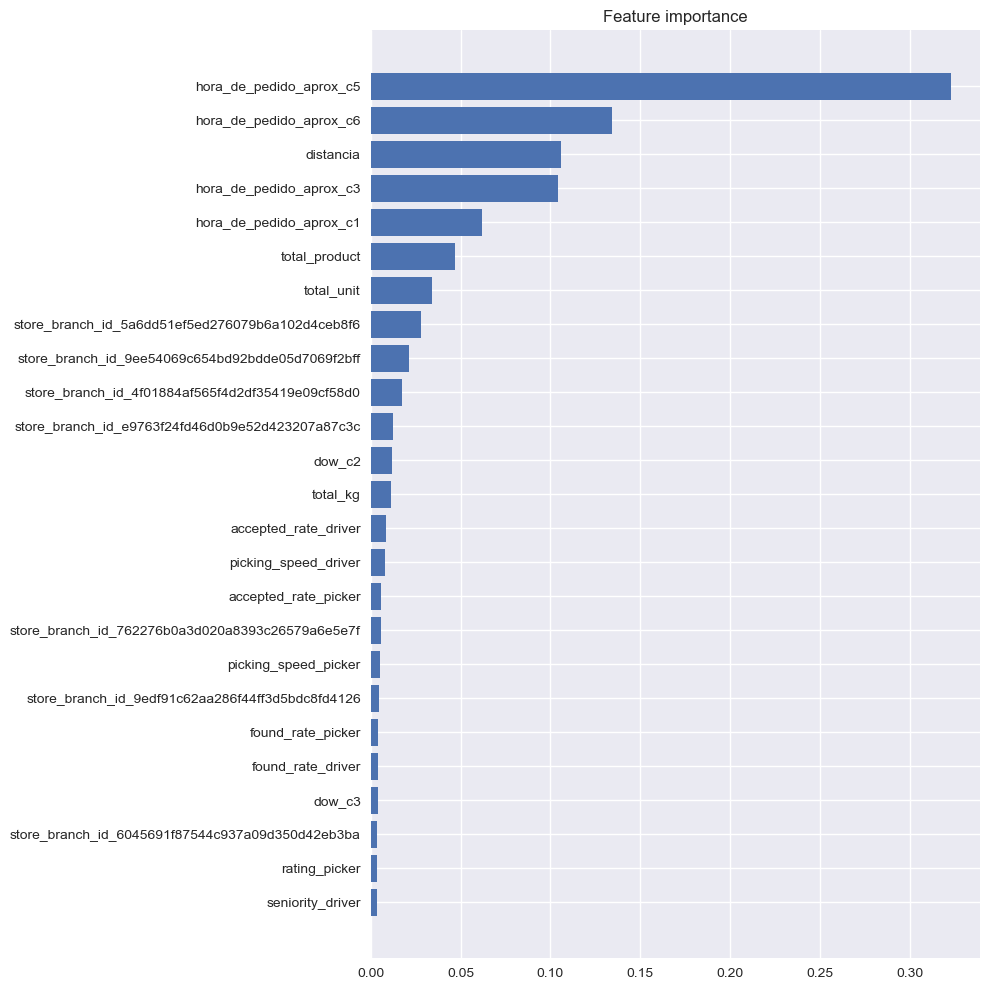


Fitting 5 folds for each of 36 candidates, totalling 180 fits
Los resultados para la variable total_product_cat = 1 son:
El error cuadrático medio es 5017.20, mientras que su raiz es 70.83
El error absoluto mediano es 16.61
Comienza identificación de top n variables relevantes...


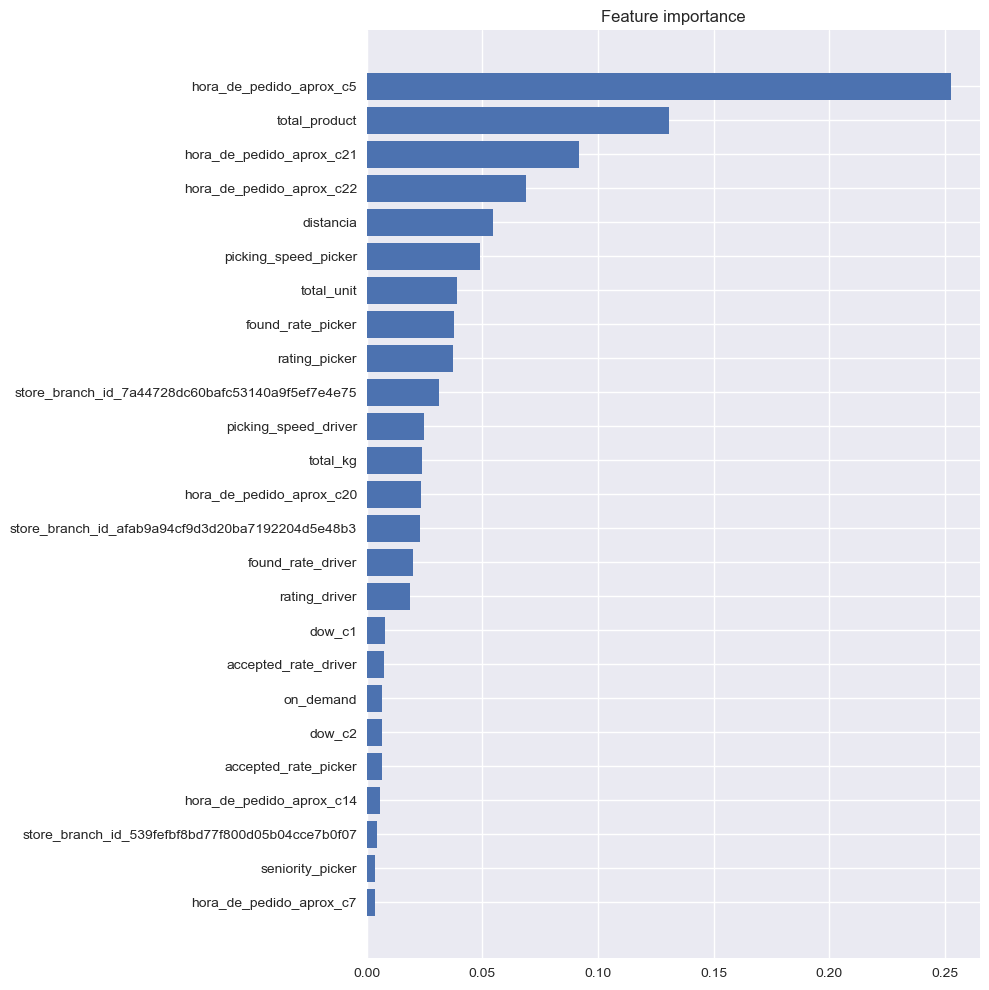

In [21]:
df_aux = df_modelo.copy()
models_list = [model_gbr] * 2
grid_list = [grid_gbr] * 2
var_group = 'total_product_cat'

df_pred = segmentation_model(df_aux, models_list, var_group, grid_list, 'gb_cat')

In [22]:
orders_test = pd.merge(orders_test, df_pred, how='inner', left_on = 'order_id', right_on = 'order_id')
orders_test.head()

,order_id,Elastic_Net_puro,Gradient_puro,rf_puro,Elastic_Net_Cat,gb_cat
0,c5fe2b7c2f032b84786701bfcc8e4fb4,106.219657,106.852542,96.294018,106.771873,107.783089
1,d455762a86db4f47f649f5235589ca8d,79.630490,79.219511,86.323151,75.229438,70.095444
2,d1b3af61078d65209e6d55aea6482856,74.203378,92.432045,78.895219,82.564872,82.972093
3,170136b204ce794ef73a3b8027725b68,108.926618,96.395305,104.622655,102.544302,93.527575
4,1cdd5e0e7f17a4fdb43d33ba8ec916d6,56.539377,64.589044,59.750017,46.573131,63.506621


### 3. EN - GB.
Modelo que aplica EN para los productos de categoría 0 y GB para los productos de categoría 1.

Fitting 5 folds for each of 16 candidates, totalling 80 fits
Los resultados para la variable total_product_cat = 0 son:
El error cuadrático medio es 1363.61, mientras que su raiz es 36.93
El error absoluto mediano es 14.53
Comienza identificación de top n variables relevantes...


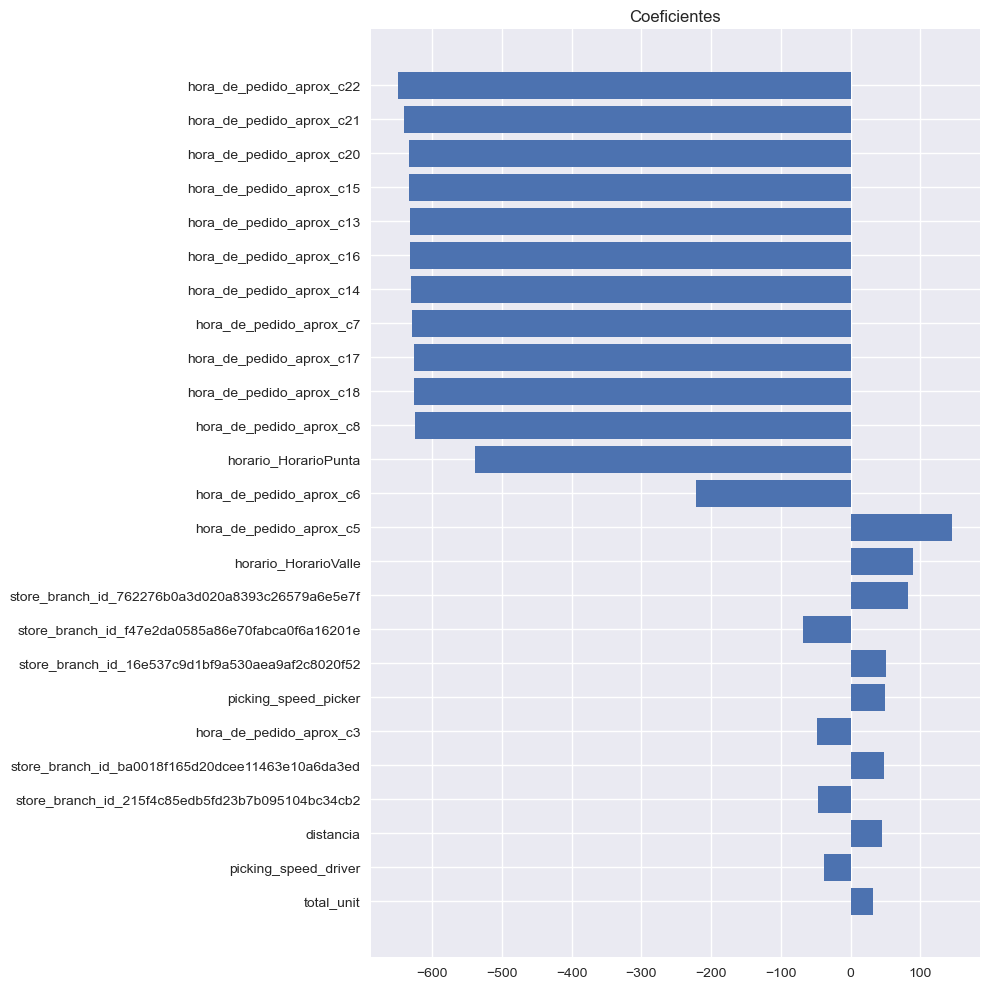


Fitting 5 folds for each of 36 candidates, totalling 180 fits
Los resultados para la variable total_product_cat = 1 son:
El error cuadrático medio es 5017.20, mientras que su raiz es 70.83
El error absoluto mediano es 16.61
Comienza identificación de top n variables relevantes...


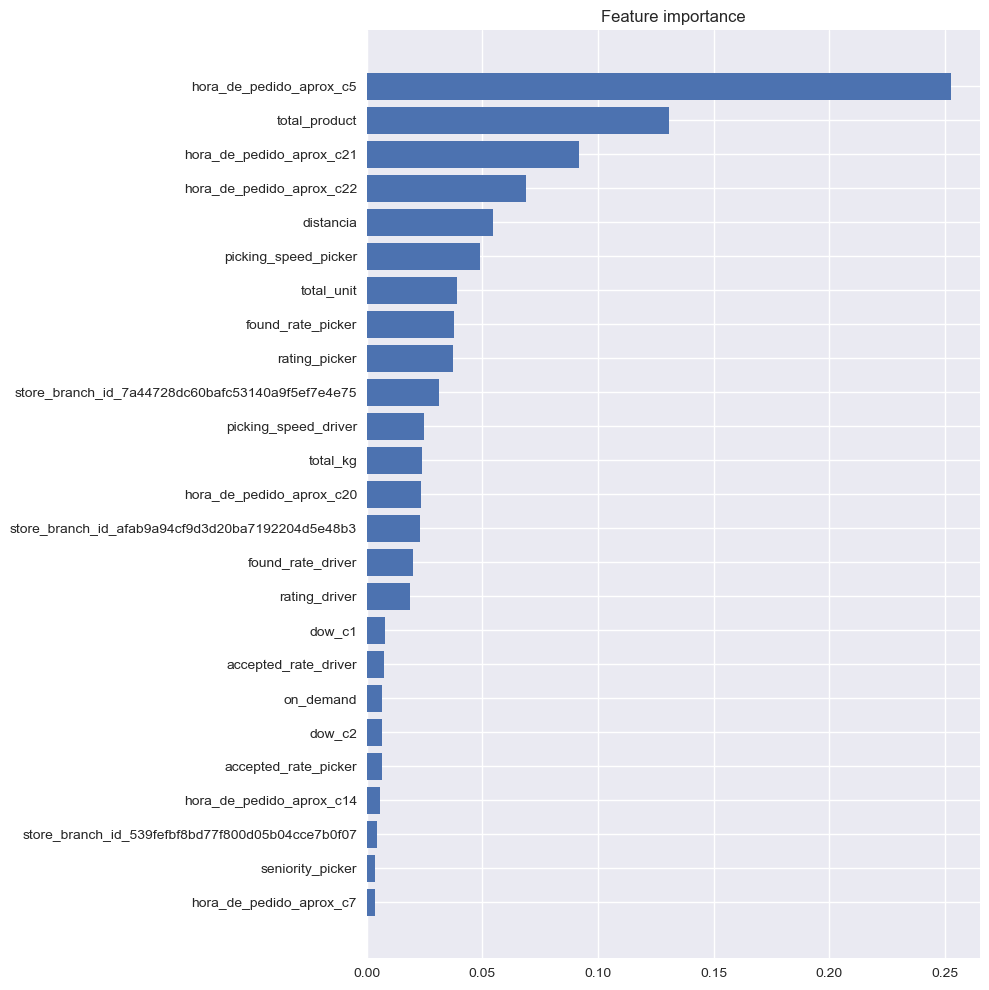

In [23]:
df_aux = df_modelo.copy()
models_list = [model_en, model_gbr]
grid_list = [grid_en, grid_gbr]
var_group = 'total_product_cat'

df_pred = segmentation_model(df_aux, models_list, var_group, grid_list, 'en_gb')

In [24]:
orders_test = pd.merge(orders_test, df_pred, how='inner', left_on = 'order_id', right_on = 'order_id')
orders_test.head()

,order_id,Elastic_Net_puro,Gradient_puro,rf_puro,Elastic_Net_Cat,gb_cat,en_gb
0,c5fe2b7c2f032b84786701bfcc8e4fb4,106.219657,106.852542,96.294018,106.771873,107.783089,107.783089
1,d455762a86db4f47f649f5235589ca8d,79.630490,79.219511,86.323151,75.229438,70.095444,75.229438
2,d1b3af61078d65209e6d55aea6482856,74.203378,92.432045,78.895219,82.564872,82.972093,82.972093
3,170136b204ce794ef73a3b8027725b68,108.926618,96.395305,104.622655,102.544302,93.527575,93.527575
4,1cdd5e0e7f17a4fdb43d33ba8ec916d6,56.539377,64.589044,59.750017,46.573131,63.506621,46.573131


### 4. GB - EN.
Modelo que aplica GB sobre la categoría 0, pero EN sobre la categoríua 1.

Fitting 5 folds for each of 36 candidates, totalling 180 fits
Los resultados para la variable total_product_cat = 0 son:
El error cuadrático medio es 2995.68, mientras que su raiz es 54.73
El error absoluto mediano es 14.75
Comienza identificación de top n variables relevantes...


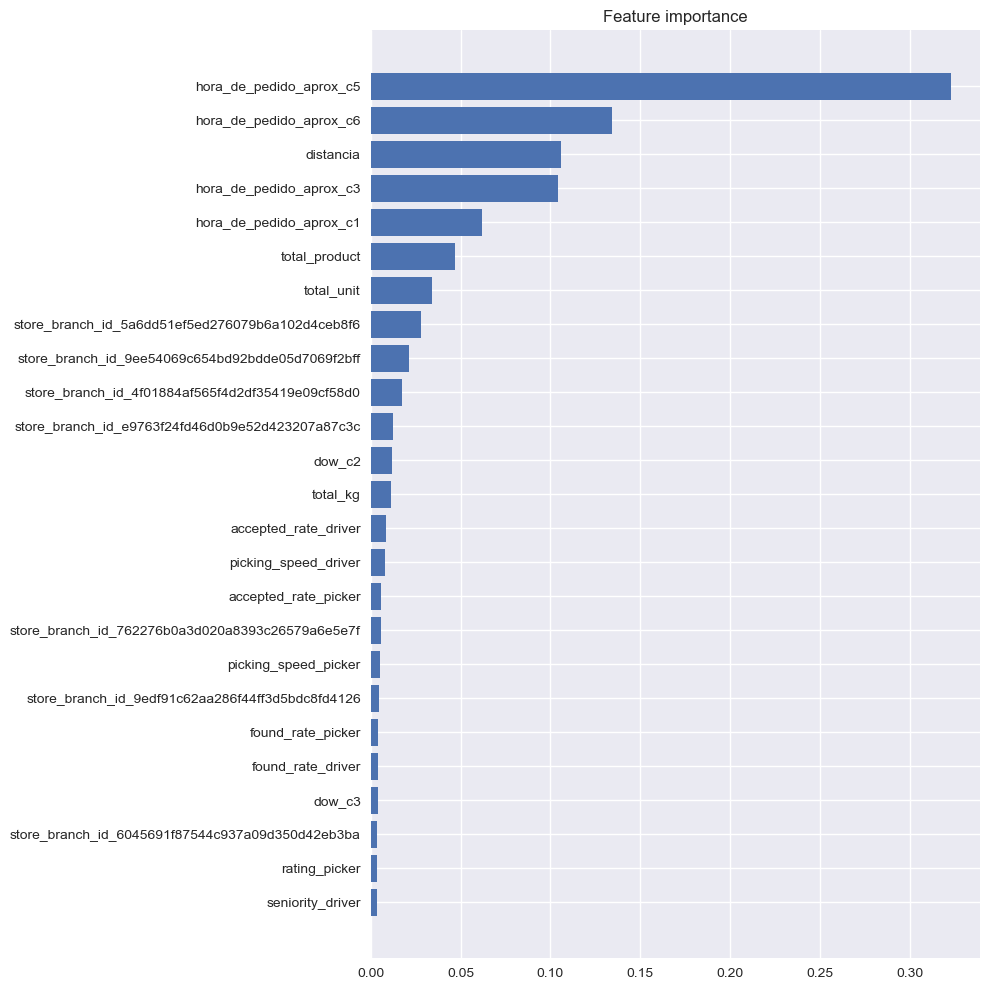


Fitting 5 folds for each of 16 candidates, totalling 80 fits
Los resultados para la variable total_product_cat = 1 son:
El error cuadrático medio es 4735.78, mientras que su raiz es 68.82
El error absoluto mediano es 16.57
Comienza identificación de top n variables relevantes...


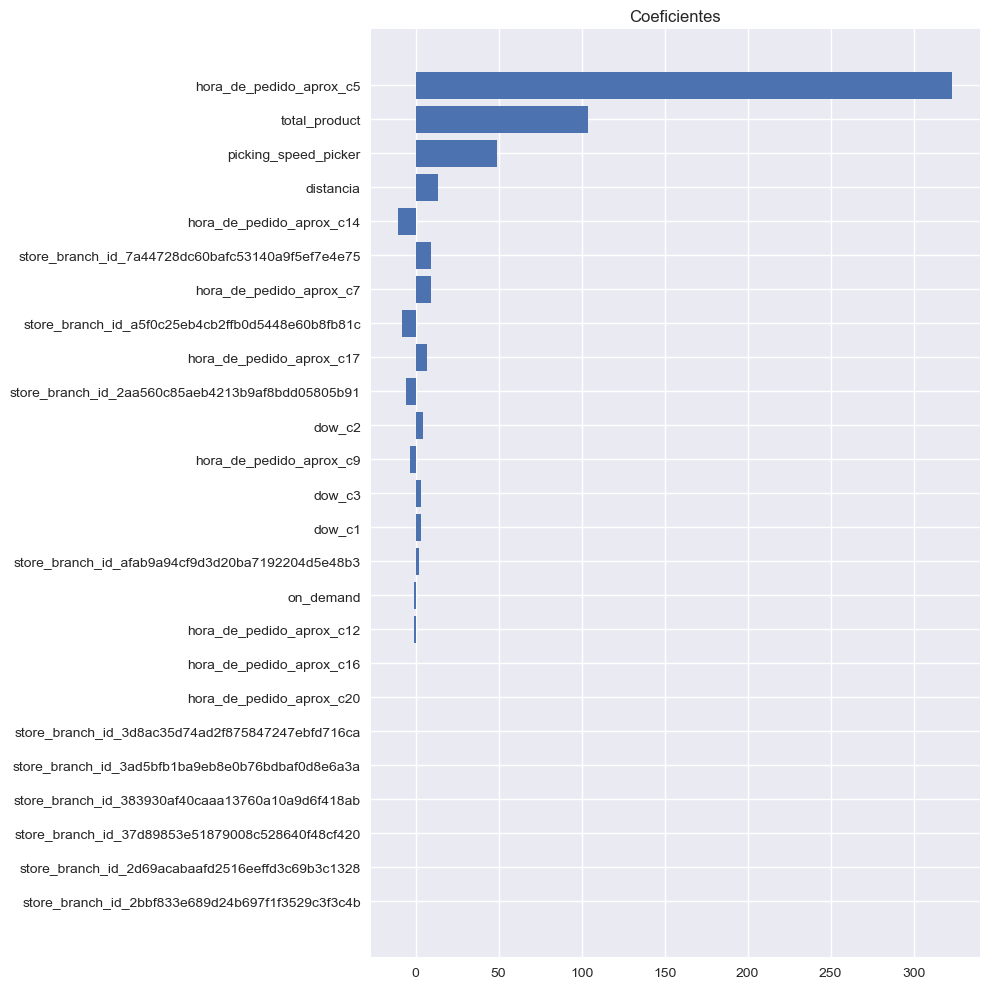

In [25]:
df_aux = df_modelo.copy()
models_list = [model_gbr, model_en]
grid_list = [grid_gbr, grid_en]
var_group = 'total_product_cat'

df_pred = segmentation_model(df_aux, models_list, var_group, grid_list, 'gb_en')

In [26]:
orders_test = pd.merge(orders_test, df_pred, how='inner', left_on = 'order_id', right_on = 'order_id')
orders_test.head()

,order_id,Elastic_Net_puro,Gradient_puro,rf_puro,Elastic_Net_Cat,gb_cat,en_gb,gb_en
0,c5fe2b7c2f032b84786701bfcc8e4fb4,106.219657,106.852542,96.294018,106.771873,107.783089,107.783089,106.771873
1,d455762a86db4f47f649f5235589ca8d,79.630490,79.219511,86.323151,75.229438,70.095444,75.229438,70.095444
2,d1b3af61078d65209e6d55aea6482856,74.203378,92.432045,78.895219,82.564872,82.972093,82.972093,82.564872
3,170136b204ce794ef73a3b8027725b68,108.926618,96.395305,104.622655,102.544302,93.527575,93.527575,102.544302
4,1cdd5e0e7f17a4fdb43d33ba8ec916d6,56.539377,64.589044,59.750017,46.573131,63.506621,46.573131,63.506621


### 5. RF - RF
Modelo que aplica Random Forest Regressor sobre ambas categorías.

Fitting 5 folds for each of 60 candidates, totalling 300 fits
Los resultados para la variable total_product_cat = 0 son:
El error cuadrático medio es 3901.67, mientras que su raiz es 62.46
El error absoluto mediano es 15.25
Comienza identificación de top n variables relevantes...


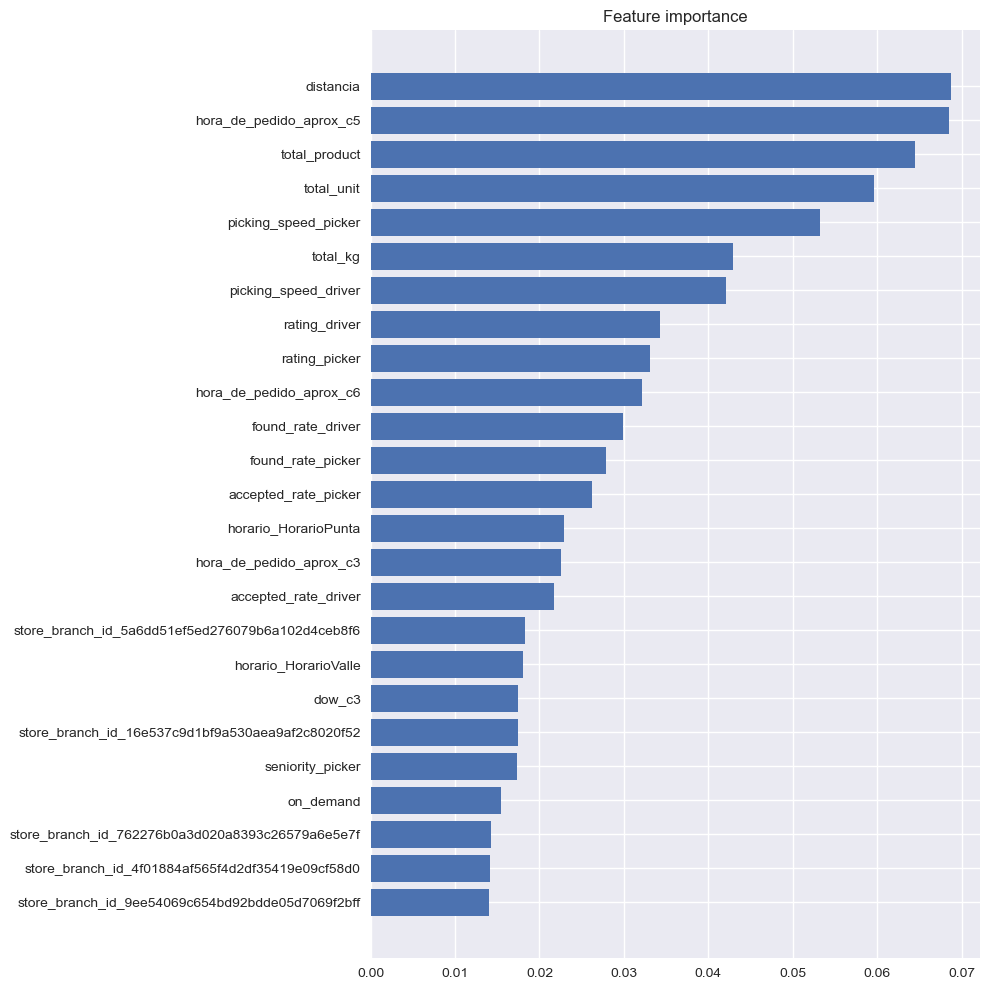


Fitting 5 folds for each of 60 candidates, totalling 300 fits
Los resultados para la variable total_product_cat = 1 son:
El error cuadrático medio es 4845.20, mientras que su raiz es 69.61
El error absoluto mediano es 16.49
Comienza identificación de top n variables relevantes...


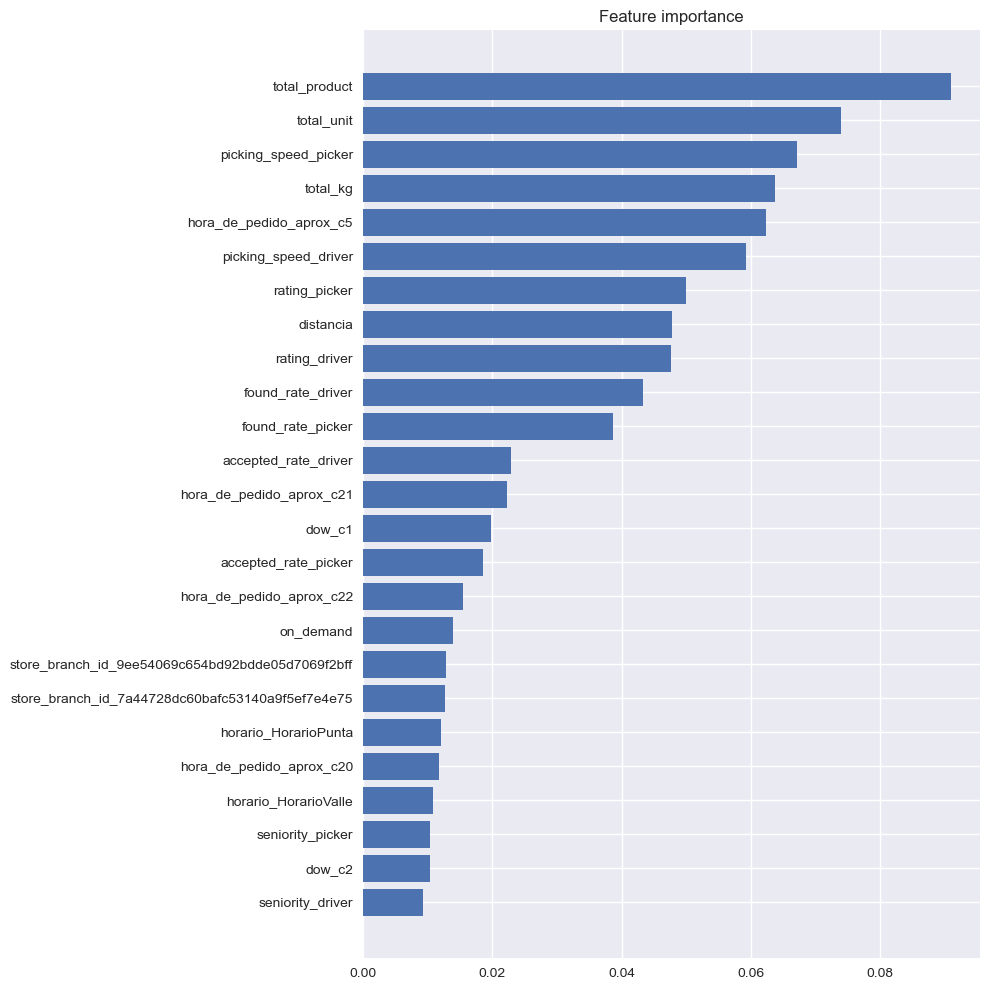

In [27]:
df_aux = df_modelo.copy()
models_list = [model_rf] * 2
grid_list = [grid_rf] * 2
var_group = 'total_product_cat'

df_pred = segmentation_model(df_aux, models_list, var_group, grid_list, 'rf_cat')

In [28]:
orders_test = pd.merge(orders_test, df_pred, how='inner', left_on = 'order_id', right_on = 'order_id')
orders_test.head()

,order_id,Elastic_Net_puro,Gradient_puro,rf_puro,Elastic_Net_Cat,gb_cat,en_gb,gb_en,rf_cat
0,c5fe2b7c2f032b84786701bfcc8e4fb4,106.219657,106.852542,96.294018,106.771873,107.783089,107.783089,106.771873,107.334604
1,d455762a86db4f47f649f5235589ca8d,79.630490,79.219511,86.323151,75.229438,70.095444,75.229438,70.095444,83.463422
2,d1b3af61078d65209e6d55aea6482856,74.203378,92.432045,78.895219,82.564872,82.972093,82.972093,82.564872,81.767489
3,170136b204ce794ef73a3b8027725b68,108.926618,96.395305,104.622655,102.544302,93.527575,93.527575,102.544302,92.041383
4,1cdd5e0e7f17a4fdb43d33ba8ec916d6,56.539377,64.589044,59.750017,46.573131,63.506621,46.573131,63.506621,60.896548


**Comentarios**  
Con el modelo anterior se cierran los modelos analizados de cara a las segmentaciones. Si bien se exploraron otras combinaciones, estas fueron desestimadas debido a que no presentaban mejoras.

## Analizando errores
A continuación, se presenta el error de los distintos modelos construidos.

In [29]:
lista_modelos = list(orders_test.columns)
lista_modelos.remove('order_id')
lista_modelos = ['modelo_campeon'] + lista_modelos 
lista_modelos

df_result = pd.merge(df, orders_test, how='inner', left_on = 'order_id', right_on = 'order_id', suffixes = ('_order', '_store'))
with pd.option_context("display.max_columns", None):
    display(df_result.head(n = 5))

,order_id,lat_order,lng_order,dow,promised_time,actual_time,on_demand,picker_id,driver_id,store_branch_id,total_minutes,actual_reception_time,promised_delivery_time,total_minutes_td,order_time,model_1_dt_time,model_1_time,store,lat_store,lng_store,shopper_id_picker,seniority_picker,found_rate_picker,picking_speed_picker,accepted_rate_picker,rating_picker,shopper_id_driver,seniority_driver,found_rate_driver,picking_speed_driver,accepted_rate_driver,rating_driver,total_product,real_total_unit,real_total_kg,real_without_product,total_unit,total_kg,distancia,hora_de_pedido_aprox,horario,total_product_cat,Elastic_Net_puro,Gradient_puro,rf_puro,Elastic_Net_Cat,gb_cat,en_gb,gb_en,rf_cat
0,0d37a1eea001f01b40232ffd496ff663,18.17771,-10.03570,2,13:00:00,10:28:10,False,c4c722114a82fa21654e57e9636d68b0,c4c722114a82fa21654e57e9636d68b0,2bbf833e689d24b697f1f3529c3f3c4b,206.599732,1900-01-01 10:28:10,1900-01-01 13:00:00,0 days 03:26:35.983919999,1900-01-01 07:01:34.016080001,0 days 05:58:25.983919999,358.433065,387d4a5b65cf4bf00ad805c4b00eed01,18.16396,-10.03289,c4c722114a82fa21654e57e9636d68b0,ADVANCED,0.85,1.14,1.00,4.76,c4c722114a82fa21654e57e9636d68b0,ADVANCED,0.85,1.14,1.00,4.76,103.0,114.0,40.614,20.0,150.0,39.562,1.557488,7,HorarioValle,1,218.148031,177.116429,182.909718,194.488907,195.614060,195.614060,194.488907,183.909752
1,e0ad6533b6cd9a382ec6c1d473c5036c,18.22911,-10.03226,2,11:00:00,10:07:53,False,06a71e8ab0c6db5ce22a4689fd76a3f4,06a71e8ab0c6db5ce22a4689fd76a3f4,afd0a7b8d546fcc697bb93a5934b65c3,130.321208,1900-01-01 10:07:53,1900-01-01 11:00:00,0 days 02:10:19.272480,1900-01-01 07:57:33.727520000,0 days 03:02:26.272480,182.437875,452ae015bf846e1d2932b7ea15720d64,18.23159,-10.03145,06a71e8ab0c6db5ce22a4689fd76a3f4,ADVANCED,0.86,1.89,1.00,4.92,06a71e8ab0c6db5ce22a4689fd76a3f4,ADVANCED,0.86,1.89,1.00,4.92,44.0,28.0,11.575,3.0,31.0,7.721,0.288728,7,HorarioValle,1,115.288547,112.477808,129.182106,129.873064,119.177568,119.177568,129.873064,124.705551
2,073eca5efe7ebb1073ec80cb90185c20,18.22078,-10.04173,2,12:00:00,11:00:15,False,e0322b49c16e71de1fe1837d98f23468,e0322b49c16e71de1fe1837d98f23468,3dd9ae393aa5327edfb27388758436bd,65.901589,1900-01-01 11:00:15,1900-01-01 12:00:00,0 days 01:05:54.095340,1900-01-01 09:54:20.904660000,0 days 02:05:39.095340,125.651589,0fae7b61265bc7ca4ce4d81440b62501,18.26223,-10.04150,e0322b49c16e71de1fe1837d98f23468,ADVANCED,0.89,1.58,1.00,5.00,e0322b49c16e71de1fe1837d98f23468,ADVANCED,0.89,1.58,1.00,5.00,2.0,2.0,0.000,0.0,2.0,0.000,4.609100,9,HorarioPunta,0,65.891289,67.469024,68.568866,68.296517,67.769949,68.296517,67.769949,63.712063
3,c1800bdd3c666b497b39d6e526917167,18.22094,-10.04172,2,10:00:00,8:46:04,False,a083ea904c55052cdb58917ed790ca96,a083ea904c55052cdb58917ed790ca96,2d69acabaafd2516eeffd3c69b3c1328,665.212000,1900-01-01 08:46:04,1900-01-01 10:00:00,0 days 11:05:12.720000,1899-12-31 21:40:51.280000000,0 days 12:19:08.720000,739.145333,60e4c4e1c1a8bc79123738227b9d0b08,18.21834,-10.04157,a083ea904c55052cdb58917ed790ca96,ADVANCED,0.86,1.50,0.96,4.72,a083ea904c55052cdb58917ed790ca96,ADVANCED,0.86,1.50,0.96,4.72,20.0,22.0,0.505,2.0,25.0,0.500,0.289541,21,HorarioValle,1,69.058829,78.243481,80.451092,86.202374,62.989602,62.989602,86.202374,74.271448
4,b4c64ceaa31265a4b2ff0dec82b9beeb,18.21779,-10.03446,2,17:00:00,16:33:37,False,2bfd559c4bef0e59fee43bf322e3ea5e,2bfd559c4bef0e59fee43bf322e3ea5e,f45fd1f4de72b451f9d99e2a033de337,83.232147,1900-01-01 16:33:37,1900-01-01 17:00:00,0 days 01:23:13.928820,1900-01-01 15:10:23.071180000,0 days 01:49:36.928820,109.615480,387d4a5b65cf4bf00ad805c4b00eed01,18.22698,-10.03056,2bfd559c4bef0e59fee43bf322e3ea5e,ADVANCED,0.86,1.55,0.92,4.96,2bfd559c4bef0e59fee43bf322e3ea5e,ADVANCED,0.86,1.55,0.92,4.96,1.0,3.0,0.000,0.0,3.0,0.000,1.101779,15,HorarioValle,0,51.718093,60.488885,68.779240,50.938480,62.309263,50.938480,62.309263,59.740173


In [30]:
columnas_drop = ['order_id', 'lat_order', 'lng_order', 
        'on_demand', 'picker_id', 'driver_id', 'store_branch_id',
       'actual_reception_time', 'promised_delivery_time',
       'total_minutes_td', 'order_time', 'model_1_dt_time',
       'store', 'lat_store', 'lng_store', 'shopper_id_picker',
       'seniority_picker', 'found_rate_picker', 'picking_speed_picker',
       'accepted_rate_picker', 'rating_picker', 'shopper_id_driver',
       'seniority_driver', 'found_rate_driver', 'picking_speed_driver',
       'accepted_rate_driver', 'rating_driver', 'total_product',
       'real_total_unit', 'real_total_kg', 'real_without_product',
       'total_unit', 'total_kg', 'distancia']

df_analisis = df_result.copy().drop(columns = columnas_drop)
df_analisis = df_analisis.rename(columns={'model_1_time': 'modelo_campeon'})
df_analisis.head()

,dow,promised_time,actual_time,total_minutes,modelo_campeon,hora_de_pedido_aprox,horario,total_product_cat,Elastic_Net_puro,Gradient_puro,rf_puro,Elastic_Net_Cat,gb_cat,en_gb,gb_en,rf_cat
0,2,13:00:00,10:28:10,206.599732,358.433065,7,HorarioValle,1,218.148031,177.116429,182.909718,194.488907,195.614060,195.614060,194.488907,183.909752
1,2,11:00:00,10:07:53,130.321208,182.437875,7,HorarioValle,1,115.288547,112.477808,129.182106,129.873064,119.177568,119.177568,129.873064,124.705551
2,2,12:00:00,11:00:15,65.901589,125.651589,9,HorarioPunta,0,65.891289,67.469024,68.568866,68.296517,67.769949,68.296517,67.769949,63.712063
3,2,10:00:00,8:46:04,665.212000,739.145333,21,HorarioValle,1,69.058829,78.243481,80.451092,86.202374,62.989602,62.989602,86.202374,74.271448
4,2,17:00:00,16:33:37,83.232147,109.615480,15,HorarioValle,0,51.718093,60.488885,68.779240,50.938480,62.309263,50.938480,62.309263,59.740173


#### Error por categoría producto.

In [31]:
# Se genera un reporte para analizar los resultados que está categorizado
report = pd.concat([
    calcular_error_modelo(df_analisis, model_i, 'total_product_cat') for model_i in lista_modelos
],
axis = 0)
#report_hra.astype(float).to_csv('report.csv', sep = ';', decimal = ',')
report.astype(float).to_csv('reportads.csv', sep = ';', decimal = ',')


In [32]:
report

total_product_cat,0.0,1.0
modelo_campeon_ErrorMedianoAbsoluto,33.116667,38.466667
modelo_campeon_ErrorCuadraticoMedio,1733.036593,2393.313919
Elastic_Net_puro_ErrorMedianoAbsoluto,14.149084,16.691173
Elastic_Net_puro_ErrorCuadraticoMedio,1570.219592,2739.449103
Gradient_puro_ErrorMedianoAbsoluto,15.098941,17.651298
Gradient_puro_ErrorCuadraticoMedio,3050.326985,4547.099619
rf_puro_ErrorMedianoAbsoluto,14.559013,16.677929
rf_puro_ErrorCuadraticoMedio,3632.583241,4724.633645
Elastic_Net_Cat_ErrorMedianoAbsoluto,14.527433,16.572650
Elastic_Net_Cat_ErrorCuadraticoMedio,1363.614952,4735.776307


**Comentarios**  
La tabla anterior muetsra el desempeño de los distintos modelos para las dos métricas y para ambas categorías. Rápidamente, se observa que Elastic Net tiene un desempeño muy bueno, además de que es el modelo más simple. Esto es cierto tanto en la versión Elastic_Net_puro como en Elastic_net_cat. De hecho la versión categorizada presenta un desempeño ligeramente mejor.  

Se destaca que, por ejemplo, se decidió no ahondar más en el random forest ya que no presenta una mejoría clara respecto a su versión pura. Además, es un modelo cuyo entrenamiento toma más tiempo, de modo que no presenta buenas razones para explorarlo en este problema.


#### Error completo

In [33]:
df_analisis_temp = df_analisis.copy()
df_analisis_temp['CantidadDatos'] = 'Total'

report_total = pd.concat([
    calcular_error_modelo(df_analisis_temp, model_i, 'CantidadDatos') for model_i in lista_modelos
],
axis = 0)
#report_hra.astype(float).to_csv('report.csv', sep = ';', decimal = ',')
#report_total.astype(float).to_csv('reportads.csv', sep = ';', decimal = ',')
report_total.astype(float).to_csv('report_segmentado.csv', sep = ';', decimal = ',')
report_total



CantidadDatos,Total
modelo_campeon_ErrorMedianoAbsoluto,35.166667
modelo_campeon_ErrorCuadraticoMedio,1978.563447
Elastic_Net_puro_ErrorMedianoAbsoluto,15.212557
Elastic_Net_puro_ErrorCuadraticoMedio,2005.00242
Gradient_puro_ErrorMedianoAbsoluto,15.891632
Gradient_puro_ErrorCuadraticoMedio,3606.908077
rf_puro_ErrorMedianoAbsoluto,15.416616
rf_puro_ErrorCuadraticoMedio,4038.666699
Elastic_Net_Cat_ErrorMedianoAbsoluto,15.035472
Elastic_Net_Cat_ErrorCuadraticoMedio,2617.567094


**Comentarios**  
La tabla anterior también muestra resultados, sin embargo, esta vez son a nivel Total. Respecto a los modelos Puros vs sus versiones categorizadas, se ve que existen mejoras en Elastic Net y en Gradient Boosting para el Error Mediano Absoluto. En cambio, el error cuadrático medio empeora. Esto se debe a que este último es un indicador que se ve más afectado por outliers en el error. De modo que, al segmentar, es posible que haya observaciones específicas cuyo error sube, sin embargo, en el general la situación mejora, lo que se ve en el error mediano absoluto.

Al observar solo errores medianos absolutos, todos los valores de los modelos desafiantes están en torno a los 15 minutos. Elastic Net puro queda en 15.21 minutos, mientras que Elastic Net categorizado queda en 15.03. Ese es el mejor resultado que se logró, sin embargo, son solo 12 segundos de mejora. En cambio, el error cuadrático medio pasa de 2005 a 2617, lo que representa datos con un error mayor. 

Dada la baja mejora en el error, además de que al segmentar los modelos se vuelven más complejos, se decide no continuar con un camino de modelos segmentados. Podría llegar a ser interesante cómo cambia esta conclusión con más datos. Así, el modelo a utilizar continúa siendo Elastic Net en su versión depurada, ya sea considerando los outliers u omitiéndolos. Dicha decisión tiene que ver más con el negocio.